In [1]:
import os
import copy

In [2]:
os.chdir(".")

In [3]:

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

import opt_utils 
import testCase  

%matplotlib inline 
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

E:\python\Learn\DL\learn_optimizer\opt_utils.py:76: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(parameters['W' + str(l)].shape == layer_dims[l], layer_dims[l-1])
E:\python\Learn\DL\learn_optimizer\opt_utils.py:77: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(parameters['W' + str(l)].shape == layer_dims[l], 1)


## Get Mini_batch

In [4]:
# 获得mini_batch 数据
def get_batches(X,Y,mini_batch_size=64,seed=0):
    """
        参数：
            X - 输入的数据，维度为（特征值/0层神经元的个数，m（样本个数））
            Y - 输入数据的标签，维度为（类别个数/最后一层神经元的个数，m）
            mini_batch_size - 一个batch的大小
            seed - 随机种子，用于shuffle数据的标准
        
        返回：
            mini_batches - 分为若干个batch的数据
    """
    np.random.seed(seed)
    m = X.shape[1]
    mini_batchs = []
    # 对下标也就是位置进行shuffle    
    order = np.random.permutation(m)
    # 做对应位置的shuffle
    shuffle_x = X[:, order]
    shuffle_y = Y[:, order].reshape(1,m)
    
    mini_batchs = [(shuffle_x[:,i * mini_batch_size : (i + 1) * mini_batch_size], shuffle_y[:, i * mini_batch_size : (i + 1) * mini_batch_size]) for i in range(m // mini_batch_size) ]
    # 相当于 
    #for k in range(0,num_complete_minibatches):
    #     mini_batch_X = shuffle_x[:,i * mini_batch_size:(i+1)*mini_batch_size]
    #     mini_batch_Y = shuffle_y[:,i * mini_batch_size:(i+1)*mini_batch_size]
    #mini_batchs.append(（mini_batch_X, mini_batch_Y）)

    if m % mini_batch_size != 0:
        rest_p = m // mini_batch_size
        mini_batchs.append((shuffle_x[:, rest_p * mini_batch_size:], shuffle_y[:, rest_p * mini_batch_size :]))
    return mini_batchs
    

In [5]:
#测试get_batches
print("-------------测试get_batches-------------")
X_assess,Y_assess,mini_batch_size = testCase.random_mini_batches_test_case()
mini_batches = get_batches(X_assess,Y_assess)

print("第1个mini_batch_X 的维度为：",mini_batches[0][0].shape)
print("第1个mini_batch_Y 的维度为：",mini_batches[0][1].shape)
print("第2个mini_batch_X 的维度为：",mini_batches[1][0].shape)
print("第2个mini_batch_Y 的维度为：",mini_batches[1][1].shape)
print("第3个mini_batch_X 的维度为：",mini_batches[2][0].shape)
print("第3个mini_batch_Y 的维度为：",mini_batches[2][1].shape)


-------------测试get_batches-------------
第1个mini_batch_X 的维度为： (12288, 64)
第1个mini_batch_Y 的维度为： (1, 64)
第2个mini_batch_X 的维度为： (12288, 64)
第2个mini_batch_Y 的维度为： (1, 64)
第3个mini_batch_X 的维度为： (12288, 20)
第3个mini_batch_Y 的维度为： (1, 20)


## GD

In [6]:
# 梯度下降更新参数
def update_params_gd(parameters,grads,lr):
    """
        参数：
            parameters - 字典，包含了要更新的参数：
                parameters['W' + str(l)] = Wl
                parameters['b' + str(l)] = bl
            grads - 字典，包含了每一个梯度值用以更新参数
                grads['dW' + str(l)] = dWl
                grads['db' + str(l)] = dbl
            lr - 学习率

        返回值：
            parameters - 字典，包含了更新后的参数
    """
    
    L = len(parameters) // 2 #神经网络的层数
    
    #更新每个参数
    for l in range(L):
        parameters["W" + str(l +1)] = parameters["W" + str(l + 1)] - lr * grads["dW" + str(l + 1)]
        parameters["b" + str(l +1)] = parameters["b" + str(l + 1)] - lr * grads["db" + str(l + 1)]
    
    return parameters


## Momentum

In [7]:
# 初始化v0
def initialize_v(parameters):
    """
        参数：
            parameters - 包含各个层的w和b的字典
        
        返回：
            v - 与parameters的结构一样，但是数值变为1，用于计算dw和db的指数加权平均
    
    """
    L = len(parameters) // 2
    v = {}
    for i in range(L):
        v["dW" + str(i + 1)] = np.zeros_like(parameters["W" + str(i + 1)])
        v["db" + str(i + 1)] = np.zeros_like(parameters["b" + str(i + 1)])
    return v


In [8]:
#测试initialize_v
print("-------------测试initialize_v-------------")
parameters = testCase.initialize_velocity_test_case()
v = initialize_v(parameters)

print('v["dW1"] = ' + str(v["dW1"]))
print('v["db1"] = ' + str(v["db1"]))
print('v["dW2"] = ' + str(v["dW2"]))
print('v["db2"] = ' + str(v["db2"]))


-------------测试initialize_v-------------
v["dW1"] = [[0. 0. 0.]
 [0. 0. 0.]]
v["db1"] = [[0.]
 [0.]]
v["dW2"] = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v["db2"] = [[0.]
 [0.]
 [0.]]


In [9]:
# 参数更新
def update_params_momentun(parameters, grads, v, beta, lr ):
    """
        参数：
            parameters - 包含各个层的w和b的字典
            grads - 包含各个层的dw和db的字典
            beta - 超参数，用于更新v，通常为0.9
            v - 上一次产生的v
            lr - 学习率
            
        返回：
            parameters - 更新后的w和d
            v - 更新后的v，用于下一次更新使用
    
    """
    L = len(parameters) // 2
    for i in range(L):
        # 更新v
        v["dW" + str(i+1)] = beta * v["dW" + str(i+1)] + (1-beta) * grads["dW" + str(i+1)]
        v["db" + str(i+1)] = beta * v["db" + str(i+1)] + (1-beta) * grads["db" + str(i+1)]
        # 通过v来更新参数
        parameters["W" + str(i+1)] = parameters["W" + str(i+1)] - lr * v["dW" + str(i+1)] 
        parameters["b" + str(i+1)] = parameters["b" + str(i+1)] - lr * v["db" + str(i+1)]
    
    return parameters, v

In [10]:
#测试update_params_momentun
print("-------------测试update_params_momentun-------------")
parameters,grads,v = testCase.update_parameters_with_momentum_test_case()
update_params_momentun(parameters,grads,v,beta=0.9,lr=0.01)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
print('v["dW1"] = ' + str(v["dW1"]))
print('v["db1"] = ' + str(v["db1"]))
print('v["dW2"] = ' + str(v["dW2"]))
print('v["db2"] = ' + str(v["db2"]))


-------------测试update_params_momentun-------------
W1 = [[ 1.62544598 -0.61290114 -0.52907334]
 [-1.07347112  0.86450677 -2.30085497]]
b1 = [[ 1.74493465]
 [-0.76027113]]
W2 = [[ 0.31930698 -0.24990073  1.4627996 ]
 [-2.05974396 -0.32173003 -0.38320915]
 [ 1.13444069 -1.0998786  -0.1713109 ]]
b2 = [[-0.87809283]
 [ 0.04055394]
 [ 0.58207317]]
v["dW1"] = [[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = [[-0.01228902]
 [-0.09357694]]
v["dW2"] = [[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v["db2"] = [[0.02344157]
 [0.16598022]
 [0.07420442]]


## Adam

In [14]:
# 同样，对平方指数加权平均初始化,同时也对v进行初始化
def initialize_adam(parameters):
    """
        参数：
            parameters - 包含各个层的w和b的字典
        
        返回：
            v - 与parameters的结构一样，但是数值变为1，用于计算dw和db的指数加权平均
            s - 与parameters的结构一样，但是数值变为1，用于计算dw和db的平方指数加权平均
    
    """
    L = len(parameters) // 2
    s = {}
    v = {}
    for i in range(L):
        s["dW" + str(i + 1)] = np.zeros_like(parameters["W" + str(i + 1)])
        s["db" + str(i + 1)] = np.zeros_like(parameters["b" + str(i + 1)])
        
        v["dW" + str(i + 1)] = np.zeros_like(parameters["W" + str(i + 1)])
        v["db" + str(i + 1)] = np.zeros_like(parameters["b" + str(i + 1)])
    return v, s


In [15]:
#测试initialize_adam
print("-------------测试initialize_adam-------------")
parameters = testCase.initialize_adam_test_case()
v,s = initialize_adam(parameters)

print('v["dW1"] = ' + str(v["dW1"])) 
print('v["db1"] = ' + str(v["db1"])) 
print('v["dW2"] = ' + str(v["dW2"])) 
print('v["db2"] = ' + str(v["db2"])) 
print('s["dW1"] = ' + str(s["dW1"])) 
print('s["db1"] = ' + str(s["db1"])) 
print('s["dW2"] = ' + str(s["dW2"])) 
print('s["db2"] = ' + str(s["db2"])) 


-------------测试initialize_adam-------------
v["dW1"] = [[0. 0. 0.]
 [0. 0. 0.]]
v["db1"] = [[0.]
 [0.]]
v["dW2"] = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v["db2"] = [[0.]
 [0.]
 [0.]]
s["dW1"] = [[0. 0. 0.]
 [0. 0. 0.]]
s["db1"] = [[0.]
 [0.]]
s["dW2"] = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
s["db2"] = [[0.]
 [0.]
 [0.]]


In [16]:
# 参数更新
def update_params_adam(parameters, grads, v, s, t, lr = 0.01, beta_1 = 0.9, beta_2 = 0.999, epsilon=1e-8):
    """
        参数：
            parameters - 需要更新的参数包括权重和偏置
            grads - 更新参数的梯度
            lr - 学习率
            v - 上一次产生的v
            s - 上一次产生的s
            beta_1 - 超参数，用于更新v，通常为0.9
            beta_2 - 超参数， 用于更新s，通常为0.99
            epsilon - 防止Adam分母为0，通常为1e-8
        
        返回：
            parameters - 更新后的参数
            v - 更新后的v
            s - 更新后的s
    """
    L = len(parameters) // 2
    v_correct = {}
    s_correct = {}
    for i in range(L):
        # 更新v
        v["dW" + str(i+1)] = beta_1 * v["dW" + str(i+1)] + (1-beta_1) * grads["dW" + str(i+1)]
        v["db" + str(i+1)] = beta_1 * v["db" + str(i+1)] + (1-beta_1) * grads["db" + str(i+1)]   
        # 偏移修正        
        v_correct["dW" + str(i+1)] = v["dW" + str(i+1)] / (1 - np.power(beta_1, t))
        v_correct["db" + str(i+1)] = v["db" + str(i+1)] / (1 - np.power(beta_1, t))
        # 更新s
        s["dW" + str(i+1)] = beta_2 * s["dW" + str(i+1)] + (1-beta_2) * np.square(grads["dW" + str(i+1)])
        s["db" + str(i+1)] = beta_2 * s["db" + str(i+1)] + (1-beta_2) * np.square(grads["db" + str(i+1)])     
        # 便宜修正
        s_correct["dW" + str(i+1)] = s["dW" + str(i+1)] / (1 - np.power(beta_2, t))
        s_correct["db" + str(i+1)] = s["db" + str(i+1)] / (1 - np.power(beta_2, t))
        
        # 通过v来更新参数
        parameters["W" + str(i+1)] = parameters["W" + str(i+1)] - lr * (v_correct["dW" + str(i+1)] / (np.sqrt(s_correct["dW" + str(i + 1)]) + epsilon))    
        parameters["b" + str(i+1)] = parameters["b" + str(i+1)] - lr * (v_correct["db" + str(i+1)] / (np.sqrt(s_correct["db" + str(i + 1)]) + epsilon))
    return parameters, v, s

In [17]:
#测试update_with_parameters_with_adam
print("-------------测试update_params_with_adam-------------")
parameters , grads , v , s = testCase.update_parameters_with_adam_test_case()
update_params_adam(parameters,grads,v,s,t=2)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
print('v["dW1"] = ' + str(v["dW1"])) 
print('v["db1"] = ' + str(v["db1"])) 
print('v["dW2"] = ' + str(v["dW2"])) 
print('v["db2"] = ' + str(v["db2"])) 
print('s["dW1"] = ' + str(s["dW1"])) 
print('s["db1"] = ' + str(s["db1"])) 
print('s["dW2"] = ' + str(s["dW2"])) 
print('s["db2"] = ' + str(s["db2"])) 


-------------测试update_params_with_adam-------------
W1 = [[ 1.63178673 -0.61919778 -0.53561312]
 [-1.08040999  0.85796626 -2.29409733]]
b1 = [[ 1.75225313]
 [-0.75376553]]
W2 = [[ 0.32648046 -0.25681174  1.46954931]
 [-2.05269934 -0.31497584 -0.37661299]
 [ 1.14121081 -1.09244991 -0.16498684]]
b2 = [[-0.88529979]
 [ 0.03477238]
 [ 0.57537385]]
v["dW1"] = [[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = [[-0.01228902]
 [-0.09357694]]
v["dW2"] = [[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v["db2"] = [[0.02344157]
 [0.16598022]
 [0.07420442]]
s["dW1"] = [[0.00121136 0.00131039 0.00081287]
 [0.0002525  0.00081154 0.00046748]]
s["db1"] = [[1.51020075e-05]
 [8.75664434e-04]]
s["dW2"] = [[7.17640232e-05 2.81276921e-04 4.78394595e-04]
 [1.57413361e-04 4.72206320e-04 7.14372576e-04]
 [4.50571368e-04 1.60392066e-07 1.24838242e-03]]
s["db2"] = [[5.49507194e-05]
 [2.75494327e-03]
 [5.

## 加载数据

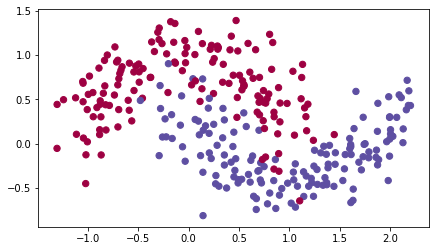

In [18]:
train_X, train_Y = opt_utils.load_dataset(is_plot=True)


## 建立模型，以三层为例

In [35]:
def model(X, Y, layers_dims, optimizer, lr=0.0007,
         mini_batch_size=64, beta_1=0.9, beta_2=0.999, 
         epsilon=1e-8, epochs= 10000, is_print=True, is_plt=True):
    """
        参数：
            X - 输入的数据
            Y - 数据的真实标签
            layers_dims - 模型的机构，包括输入数据的结构和各个隐藏层的神经元个数
            optimizer - 优化方式包括【gd（标准梯度下降）|momentum|Adam】
            lr - 学习率
            mini_batch_size - mini_batch的大小
            beta_1 - 超参数，用于更新v，通常为0.9
            beta_2 - 超参数， 用于更新s，通常为0.99
            epsilon - 防止Adam分母为0，通常为1e-8
            epochs - 迭代次数
            is_print - 是否打印损失（每100次迭代）
            is_plt - 是否画出损失图像
        
        返回：
            parameters - 更新好的参数
        
    """
    parameters = opt_utils.initialize_parameters(layers_dims)   
    costs = []
    # 用于correct参数v和s
    t = 0
    seed = 10
    if optimizer == "gd":
        pass
    elif optimizer =="momentum":
        v = initialize_v(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    else :
        print("优化方式有误")
        exit
    
    for i in range(epochs):
        seed = seed +1
        for  j in get_batches(X, Y, mini_batch_size, seed):
            t += 1
            # 前向传播
            Al, cache = opt_utils.forward_propagation(j[0], parameters)   
            # 计算损失
            cost = opt_utils.compute_cost(Al, j[1])
            
            # 反向传递
            grads = opt_utils.backward_propagation(j[0], j[1], cache)
            # 更新参数
            if optimizer == "gd":
                parameters = update_params_gd(parameters, grads, lr)   
            elif optimizer == "momentum":
                parameters, v =   update_params_momentun(parameters, grads, v, beta_1, lr)   
            else :
                parameters, v, s = update_params_adam(parameters, grads, v, s, t, lr, beta_1, beta_2, epsilon) 
        if i%100 == 0:
            costs.append(cost)
            if is_print :
                print("第%d次迭代的误差是：%f" %(i, cost), end= ",")
                pre = opt_utils.predict(X, Y, parameters)
    if is_plt:
        plt_x = len(costs)
        plt.plot(range(plt_x), costs)
        plt.ylabel("cost")
        plt.xlabel("epoch")
        plt.xticks(range(0,plt_x+1,10),[x*1000 for x in range(11)])
        plt.title("lr: " + str(lr))
        plt.show()
    return parameters

## 测试

第0次迭代的误差是：0.690736,Accuracy: 0.6066666666666667
第100次迭代的误差是：0.733981,Accuracy: 0.6166666666666667
第200次迭代的误差是：0.687981,Accuracy: 0.62
第300次迭代的误差是：0.712303,Accuracy: 0.6266666666666667
第400次迭代的误差是：0.684854,Accuracy: 0.6333333333333333
第500次迭代的误差是：0.678649,Accuracy: 0.6366666666666667
第600次迭代的误差是：0.721224,Accuracy: 0.64
第700次迭代的误差是：0.684977,Accuracy: 0.6466666666666666
第800次迭代的误差是：0.667152,Accuracy: 0.6433333333333333
第900次迭代的误差是：0.688078,Accuracy: 0.6466666666666666
第1000次迭代的误差是：0.685273,Accuracy: 0.65
第1100次迭代的误差是：0.682893,Accuracy: 0.65
第1200次迭代的误差是：0.663374,Accuracy: 0.65
第1300次迭代的误差是：0.662040,Accuracy: 0.6533333333333333
第1400次迭代的误差是：0.610479,Accuracy: 0.6533333333333333
第1500次迭代的误差是：0.647465,Accuracy: 0.6566666666666666
第1600次迭代的误差是：0.644201,Accuracy: 0.66
第1700次迭代的误差是：0.630750,Accuracy: 0.6633333333333333
第1800次迭代的误差是：0.635160,Accuracy: 0.66
第1900次迭代的误差是：0.676878,Accuracy: 0.66
第2000次迭代的误差是：0.647072,Accuracy: 0.66
第2100次迭代的误差是：0.640528,Accuracy: 0.6633333333333333
第2200次迭代的误差是：0.5

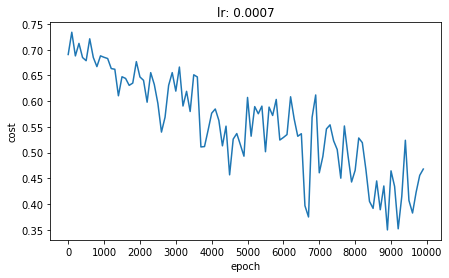

In [20]:
#使用普通的梯度下降
layers_dims = [train_X.shape[0],5,2,1]
parameters = model(train_X, train_Y, layers_dims, optimizer="gd")  


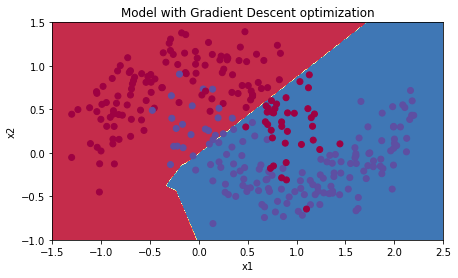

In [26]:
#绘制分类图
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
opt_utils.plot_decision_boundary(lambda x: opt_utils.predict_dec(parameters, x.T), train_X, train_Y)

第0次迭代的误差是：0.690741,Accuracy: 0.5333333333333333
第100次迭代的误差是：0.734058,Accuracy: 0.6166666666666667
第200次迭代的误差是：0.688031,Accuracy: 0.62
第300次迭代的误差是：0.712410,Accuracy: 0.6266666666666667
第400次迭代的误差是：0.684903,Accuracy: 0.6333333333333333
第500次迭代的误差是：0.678726,Accuracy: 0.6366666666666667
第600次迭代的误差是：0.721247,Accuracy: 0.64
第700次迭代的误差是：0.685007,Accuracy: 0.6466666666666666
第800次迭代的误差是：0.667225,Accuracy: 0.6433333333333333
第900次迭代的误差是：0.688096,Accuracy: 0.6466666666666666
第1000次迭代的误差是：0.685341,Accuracy: 0.65
第1100次迭代的误差是：0.682930,Accuracy: 0.65
第1200次迭代的误差是：0.663452,Accuracy: 0.65
第1300次迭代的误差是：0.662092,Accuracy: 0.6533333333333333
第1400次迭代的误差是：0.610586,Accuracy: 0.6533333333333333
第1500次迭代的误差是：0.647528,Accuracy: 0.6566666666666666
第1600次迭代的误差是：0.644284,Accuracy: 0.66
第1700次迭代的误差是：0.630792,Accuracy: 0.6633333333333333
第1800次迭代的误差是：0.635245,Accuracy: 0.66
第1900次迭代的误差是：0.676929,Accuracy: 0.66
第2000次迭代的误差是：0.647145,Accuracy: 0.66
第2100次迭代的误差是：0.640634,Accuracy: 0.6633333333333333
第2200次迭代的误差是：0.5

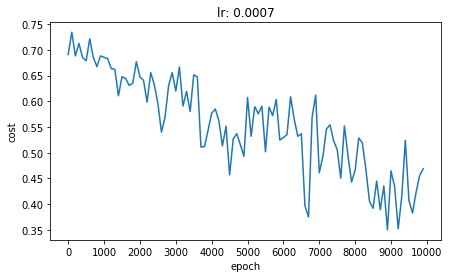

In [27]:
layers_dims = [train_X.shape[0],5,2,1]
#使用动量的梯度下降
parameters = model(train_X, train_Y, layers_dims ,optimizer="momentum")

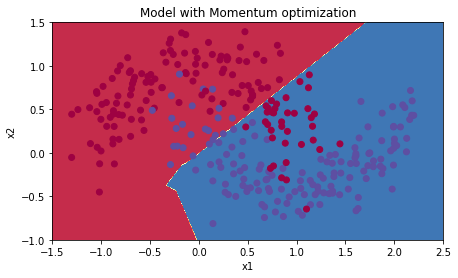

In [29]:
#绘制分类图
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
opt_utils.plot_decision_boundary(lambda x: opt_utils.predict_dec(parameters, x.T), train_X, train_Y)

第0次迭代的误差是：0.690552,Accuracy: 0.5366666666666666
第100次迭代的误差是：0.611086,Accuracy: 0.7066666666666667
第200次迭代的误差是：0.550194,Accuracy: 0.77
第300次迭代的误差是：0.328777,Accuracy: 0.89
第400次迭代的误差是：0.249773,Accuracy: 0.92
第500次迭代的误差是：0.302964,Accuracy: 0.9233333333333333
第600次迭代的误差是：0.188417,Accuracy: 0.9333333333333333
第700次迭代的误差是：0.225732,Accuracy: 0.9333333333333333
第800次迭代的误差是：0.158754,Accuracy: 0.93
第900次迭代的误差是：0.160887,Accuracy: 0.93
第1000次迭代的误差是：0.185567,Accuracy: 0.93
第1100次迭代的误差是：0.155524,Accuracy: 0.9366666666666666
第1200次迭代的误差是：0.145699,Accuracy: 0.94
第1300次迭代的误差是：0.231070,Accuracy: 0.9366666666666666
第1400次迭代的误差是：0.182052,Accuracy: 0.9366666666666666
第1500次迭代的误差是：0.174630,Accuracy: 0.9366666666666666
第1600次迭代的误差是：0.186250,Accuracy: 0.9366666666666666
第1700次迭代的误差是：0.130395,Accuracy: 0.94
第1800次迭代的误差是：0.110935,Accuracy: 0.9366666666666666
第1900次迭代的误差是：0.131091,Accuracy: 0.94
第2000次迭代的误差是：0.150852,Accuracy: 0.9366666666666666
第2100次迭代的误差是：0.138177,Accuracy: 0.9333333333333333
第2200次迭代的误差是：0.1

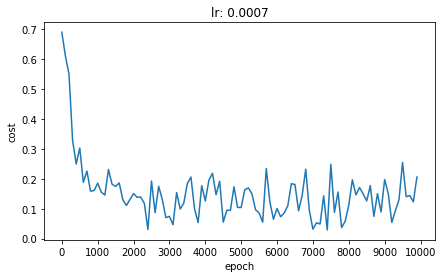

In [36]:
layers_dims = [train_X.shape[0], 5, 2, 1]
#使用Adam优化的梯度下降
parameters = model(train_X, train_Y, layers_dims, optimizer="adam")

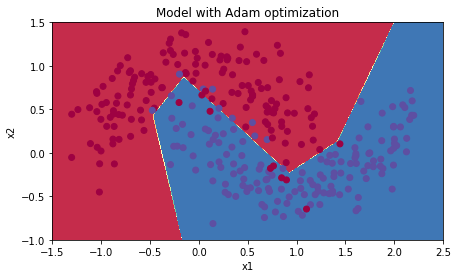

In [34]:
#绘制分类图
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
opt_utils.plot_decision_boundary(lambda x: opt_utils.predict_dec(parameters, x.T), train_X, train_Y)


Adam的效果比较好，收敛速度快，从而导致在相同的迭代次数下，图像分类更好。但是momentum在数据量简单以及时间受限的情况下并没有和普通梯度下降拉开差距，但是随着数据更加复杂，训练时间加长，会得到进一步拟合的图像分割。